In [1]:
%load_ext watermark
%watermark -p torch,lightning

torch    : 2.7.0+cu128
lightning: 2.5.2



In [2]:
import lightning as L
import torch
import torchvision
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import numpy as np

from shared_utilities import LightningModel,MNISTDataModule,plot_loss_and_acc

In [3]:
L.pytorch.seed_everything(123)

dm = MNISTDataModule()
dm.prepare_data()
dm.setup()

Seed set to 123
100%|██████████| 9.91M/9.91M [00:00<00:00, 38.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.07MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 8.41MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.32MB/s]


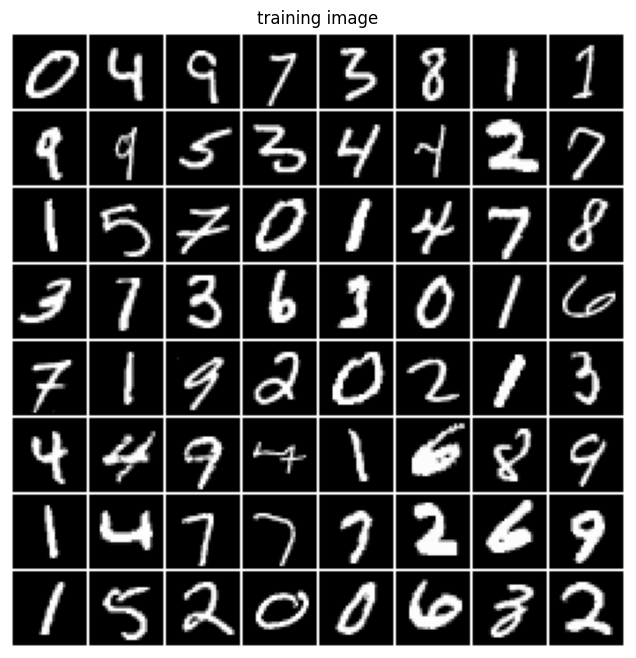

In [4]:
for images, labels in dm.train_dataloader():
    break

plt.figure(figsize=(8,8))
plt.axis('off')
plt.title("training image")
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            images[:64],
            padding=1,
            pad_value=1.0,
            normalize=True
        ),
        (1,2,0)
    )
)
plt.show()

In [5]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            torch.nn.Linear(num_features, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.ReLU(),

            torch.nn.Linear(128, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),

            #output layer
            torch.nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

In [6]:

L.seed_everything(123)

dm = MNISTDataModule()
pymodel = PyTorchMLP(num_features=784, num_classes=10)
l_model = LightningModel(model=pymodel, learning_rate=0.05, num_classes=10)

trainer = L.Trainer(
    max_epochs=10,
    accelerator='auto',
    devices='auto',
    logger=CSVLogger(save_dir='logs/', name='mlp_baseline'),
    deterministic=True,
)

Seed set to 123
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [7]:
trainer.fit(model=l_model,datamodule=dm)


  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | PyTorchMLP         | 109 K  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
109 K     Trainable params
0         Non-trainable params
109 K     Total params
0.439     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


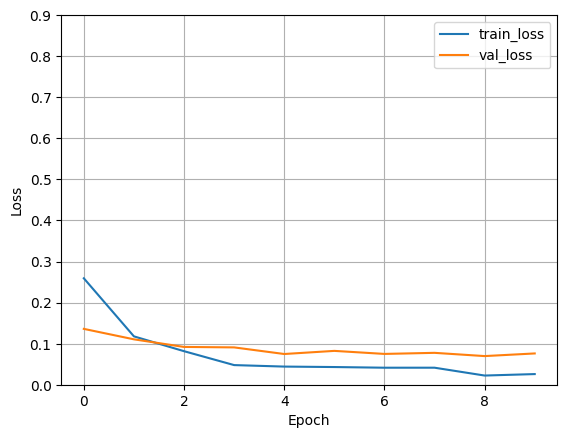

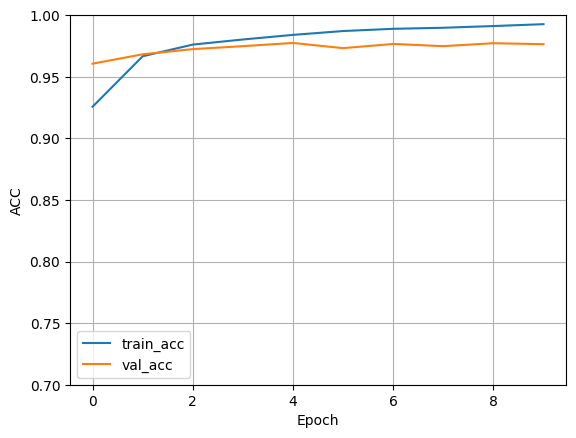

In [8]:
plot_loss_and_acc(trainer.logger.log_dir)

In [9]:
trainer.test(model=l_model, datamodule=dm)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9779000282287598     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9779000282287598}]

In [14]:
class PyTorchCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.cnn_layers = torch.nn.Sequential(
            torch.nn.Conv2d(1,3,kernel_size=5),
            torch.nn.BatchNorm2d(3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),

            #2nd layer
            torch.nn.Conv2d(3,16,kernel_size=3),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),

            #2]3nd layer
            torch.nn.Conv2d(16,32,kernel_size=3),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.fc_layer = torch.nn.Sequential(
            #hidden layer
            torch.nn.Linear(32,20),
            torch.nn.BatchNorm1d(20),
            torch.nn.ReLU(),

            #output layer
            torch.nn.Linear(20,num_classes),
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        #print(x.shape) # Trick to find FC layer input dim
        features = torch.flatten(x, start_dim=1)
        logits = self.fc_layer(features)
        return logits

In [17]:
L.seed_everything(123)

dm = MNISTDataModule()
pymodel = PyTorchCNN(num_classes = 10)
l_model = LightningModel(model = pymodel,learning_rate=0.1, num_classes=10)

trainer= L.Trainer(
    max_epochs=10,
    accelerator='auto',
    devices='auto',
    logger=CSVLogger(save_dir='logs/', name='CNN-model'),
    deterministic=True
)




💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model=l_model, datamodule=dm)


  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | PyTorchCNN         | 6.2 K  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


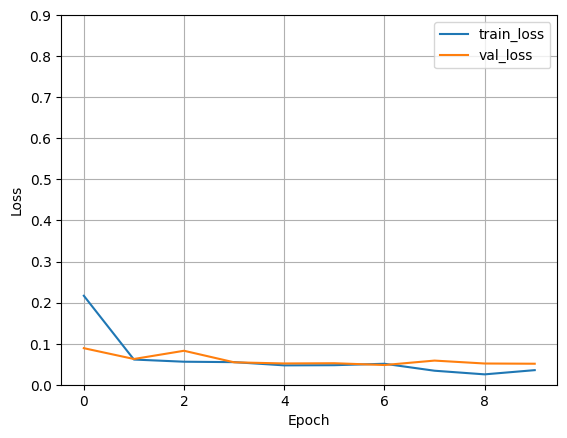

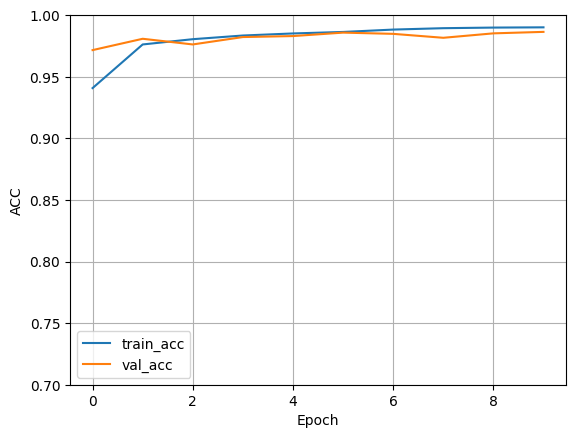

In [19]:
plot_loss_and_acc(trainer.logger.log_dir)

In [20]:
trainer.test(model=l_model, datamodule=dm)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9860000014305115     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9860000014305115}]